# Construct map from samples

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
from mpart import *

In [3]:
# sinh-arcsinh function
def sinharcsinh(z,loc,scale,skew,tail):
    '''
    To make skewed and/or non-Gaussian tailed test distributions
    skew \in R, skew > 0 leads to positive (right tilted) skew, skew < 0 leads to negative (left tilted) skew
    tail > 0, tail < 1 leads to light tails, tail > 1 leads to heavy tails.
    skew = 0, tail = 1 leads to affine function x = loc + scale*z
    See for more info: Jones, M. Chris, and Arthur Pewsey. "Sinh-arcsinh distributions." Biometrika 96.4 (2009): 761-780.
    '''
    f0 = np.sinh(tail*np.arcsinh(2))
    f = (2/f0)*np.sinh(tail*(np.arcsinh(z) + skew))
    x = loc + scale*f
    return x

In [4]:
# Make target samples
num_points = 1000
z = np.random.randn(num_points)
x = sinharcsinh(z, loc=-1, scale=1, skew=.5, tail=1)[None,:]
# x = -2 + .5*z  # For Gaussian test case

In [5]:
# For plotting and computing reference density 
rv = norm()
t = np.linspace(-3,3,100)
rho_t = rv.pdf(t)

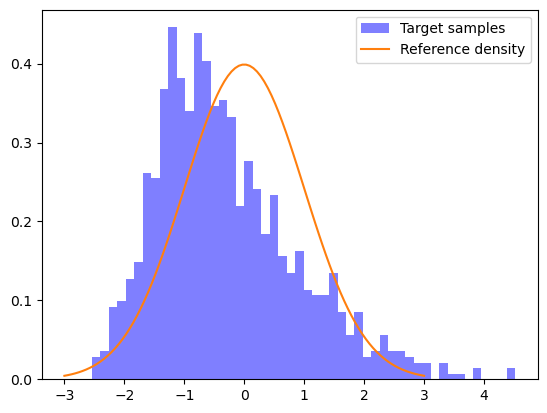

In [6]:
# Before optimization
num_bins = 50
plt.figure()
plt.hist(x.flatten(), num_bins, facecolor='blue', alpha=0.5, density=True, label='Target samples')
plt.plot(t,rho_t,label="Reference density")
plt.legend()
plt.show()

In [7]:
# Create multi-index set:
multis = np.array([[0], [1], [2], [3], [4], [5]])
# multis = np.array([[0], [1]])  # For Gaussian test case
mset = MultiIndexSet(multis)
fixed_mset = mset.fix(True)

In [8]:
# Set MapOptions and make map
opts = MapOptions()
opts.basisType = BasisTypes.HermiteFunctions
#opts.basisType = BasisTypes.PhysicistHermite
monotoneMap = CreateComponent(fixed_mset, opts)

In [9]:
# KL divergence objective
def objective(coeffs, monotoneMap, x, num_points):
    monotoneMap.SetCoeffs(coeffs)
    map_of_x = monotoneMap.Evaluate(x)
    ref_logpdf_of_map_of_x = rv.logpdf(map_of_x)
    log_det = monotoneMap.LogDeterminant(x)
    return -np.sum(ref_logpdf_of_map_of_x + log_det)/num_points

In [10]:
# Optimize
print('Starting coeffs')
print(monotoneMap.CoeffMap())
print('and error: {:.2E}'.format(objective(monotoneMap.CoeffMap(), monotoneMap, x, num_points)))
res = minimize(objective, monotoneMap.CoeffMap(), args=(monotoneMap, x, num_points), method="Nelder-Mead")
print('Final coeffs')
print(monotoneMap.CoeffMap())
print('and error: {:.2E}'.format(objective(monotoneMap.CoeffMap(), monotoneMap, x, num_points)))

Starting coeffs
[0. 0. 0. 0. 0. 0.]
and error: 1.65E+00
Final coeffs
[-0.48891915 -0.14729791  1.38680631 -0.24070162  0.26133464 -0.06371499]
and error: 1.51E+00


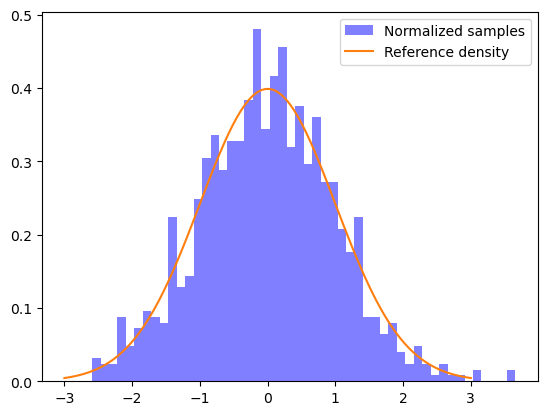

In [11]:
# After optimization plot
map_of_x = monotoneMap.Evaluate(x)
plt.figure()
plt.hist(map_of_x.flatten(), num_bins, facecolor='blue', alpha=0.5, density=True, label='Normalized samples')
plt.plot(t,rho_t,label="Reference density")
plt.legend()
plt.show()